# NERC analysis



## NERC Analysis motivation

Named Entity Recognition (NER) is a subtask of Natural Language Processing (NLP) that focuses on identifying and extracting named entities from unstructured text data. Named entities are objects, people, organizations, locations, and other specific things that have names. NER is used in various applications such as information retrieval, question answering, and text summarization. It's particularly useful for quickly extracting key information from large amounts of data because it automates the extraction process. NER is applied by training a machine learning model on a labeled dataset that contains examples of named entities and their corresponding labels. The model then uses this training data to identify named entities in new, unseen text data. NER can be a challenging task due to the ambiguity and variability of named entities in natural language, but it is an essential component of many NLP applications.

* https://www.techtarget.com/whatis/definition/named-entity-recognition-NER#:~:text=NER%20identifies%2C%20categorizes%20and%20extracts,it%20automates%20the%20extraction%20process.
* https://ijarcce.com/upload/2017/february-17/IJARCCE%2060.pdf

### Dataset description


- Used dataset for NERC analysis CrossWeigh: https://github.com/ZihanWangKi/CrossWeigh/blob/master/data/conllpp_train.txt. Crossweigh manually corrected the mistakes in the test set to form a cleaner benchmark and the developed framework Crossweigh handles the mistakes in the training set.
- This training set contains 203621 instances where the majority of the training set consists of O-tags. The distribution of the training labels is plotted in a pie chart shown down below. 
- The other golden labels (the labels that the NERC model should learn predict) from are: B-LOC (3.5%), B-PER (3.2%), B-ORG (3.1%), I-PER (2.2%), I-ORG (1.8%), B-MISC (1,7%), I-LOC (0.6%), I-MISC (0.6%).
- This shows that the training set is not balanced, there are far more O-labels. 


### Method
- First the test set is cleaned by removing unused columns such as sentence id and token id. Then the names of the columns are changed to match with the nltk.corpus of the training set. The code that is applied is from lab4.
- After computing the nltk.corpus for the test set,  spaCy is used to predict the unknown labels for this dataset.
- The train and test features are concatenated into one list after the label prediction for the test set and then split back into training and test. 
- A SVM is trained afterwards using the train features and labels and the test data is evaluated. 

### Error Analysis
- The classification report shows an accuracy of 0.93. However, the test set is relatively small and it consists mainly of O's, this label is well predicted with a recall of 0.95, precision of 0.99 and f1-score of 0.97. The other labels are not well predicted, they have lower recall, predicision and f1-scores. This results in a low macro average. 
- So we should keep in mind that although the accuracy of this model is high, the performance is not necessarily good. From the obtained results, we could conclude that this model is good at detecting "O" labels but not as good as predicting the other labels.

### Imports and installs

In [1]:
!pip install pandas
!pip install nltk
!pip install sklearn
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus.reader import ConllCorpusReader
from sklearn.feature_extraction import DictVectorizer
from sklearn import svm
from sklearn.metrics import classification_report
import spacy
import gensim

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Train set

In [5]:
from nltk.corpus.reader import ConllCorpusReader
train = ConllCorpusReader('/content/', 'conllpp_train.txt', ['words', 'pos', 'ignore', 'chunk'])
training_features = []
training_gold_labels = []
for token, pos, ne_label in train.iob_words():
    a_dict = {
        # add features
        'words': token,
        'pos': pos
    }
    training_features.append(a_dict)
    training_gold_labels.append(ne_label)

## Test set

In [71]:
data = pd.read_csv("/content/NER-final-test.tsv",sep='\t')
test = pd.DataFrame(data, columns=['token','NER','BIO', 'tag'])
test.columns = ['words','pos','ignore','chunk']

In [12]:
nlp = spacy.load('en_core_web_sm')
# Apply spacy to find the named entities.
def ner(df):
    df['pos'] = df['words'].apply(lambda x: [token.pos_ for token in nlp(x) if not token.is_space])
    df['ignore'] = df['words'].apply(lambda x: [token.tag_ for token in nlp(x) if not token.is_space])
    df['chunk'] = df['words'].apply(lambda x: [(token.ent_iob_ + '-' + token.ent_type_ if token.ent_iob_ != 'O' else 'O') if not token.is_space else ('','') for token in nlp(x)])
    return df
ner_table = ner(test)

In [13]:
def list_to_str(lst):
    return ' '.join([str(elem) for elem in lst])

ner_table['pos'] = ner_table['pos'].apply(list_to_str)
ner_table['ignore'] = ner_table['ignore'].apply(list_to_str)
ner_table['chunk'] = ner_table['chunk'].apply(list_to_str)

In [14]:
ner_table['chunk'].unique()

array(['O', 'B-CARDINAL', 'B-DATE', 'B-ORG', 'B-NORP', 'B-PERSON',
       'B-GPE', 'B-ORDINAL', 'B-LANGUAGE'], dtype=object)

In [15]:
test['chunk'] = test['chunk'].apply(lambda i: 'B-MISC' if i in ['B-CARDINAL', 'B-DATE', 'B-NORP', 'B-ORDINAL', 'B-LANGUAGE'] else i)
test['chunk'] = test['chunk'].apply(lambda i: 'B-LOC' if i == 'B-GPE' else i)
test['chunk'] = test['chunk'].apply(lambda i: 'B-PER' if i == 'B-PERSON' else i)

In [16]:
test_features = []
test_gold_labels = []
for index, row in test.iterrows():
    a_dict = {
        # add features
        'words': row['words'],
        'pos': row['pos']
    }
    test_features.append(a_dict)
    test_gold_labels.append(row['chunk'])

### Descriptive statistics about the training and test data

In [56]:
from collections import Counter
# Descriptive statistics
for tt, features, gold_labels in [('train', training_features, training_gold_labels), ('test', test_features, test_gold_labels)]:
    print(f"{tt.title()}ing instances: {len(features)}")
    print("Of which the label distribution is:")
    label_distribution = Counter(gold_labels)
    for l, i in sorted(label_distribution.items(), key=lambda x: x[1], reverse=True):
        percentage = i / len(features) * 100
        print(f"\t {l:7}: {i:7} ({percentage:.3f}%)")
    print()

# Balance analysis
train_label_distribution = Counter(training_gold_labels)
test_label_distribution = Counter(test_gold_labels)
print("Training and test data balance analysis:")
for label in train_label_distribution:
    train_count = train_label_distribution[label]
    test_count = test_label_distribution.get(label, 0)
    print(f"\t {label}: train {train_count} ({train_count/len(training_features)*100:.3f}%)" \
          f", test {test_count} ({test_count/len(test_features)*100:.2f}%)")


Training instances: 203621
Of which the label distribution is:
	 O      :  169578 (83.281%)
	 B-LOC  :    7140 (3.507%)
	 B-PER  :    6600 (3.241%)
	 B-ORG  :    6321 (3.104%)
	 I-PER  :    4528 (2.224%)
	 I-ORG  :    3704 (1.819%)
	 B-MISC :    3438 (1.688%)
	 I-LOC  :    1157 (0.568%)
	 I-MISC :    1155 (0.567%)

Testing instances: 214
Of which the label distribution is:
	 O      :     195 (91.121%)
	 B-MISC :      10 (4.673%)
	 B-LOC  :       4 (1.869%)
	 B-ORG  :       3 (1.402%)
	 B-PER  :       2 (0.935%)

Training and test data balance analysis:
	 B-ORG: train 6321 (3.104%), test 3 (1.40%)
	 O: train 169578 (83.281%), test 195 (91.12%)
	 B-MISC: train 3438 (1.688%), test 10 (4.67%)
	 B-PER: train 6600 (3.241%), test 2 (0.93%)
	 I-PER: train 4528 (2.224%), test 0 (0.00%)
	 B-LOC: train 7140 (3.507%), test 4 (1.87%)
	 I-ORG: train 3704 (1.819%), test 0 (0.00%)
	 I-MISC: train 1155 (0.567%), test 0 (0.00%)
	 I-LOC: train 1157 (0.568%), test 0 (0.00%)


### Label distribution of the training set

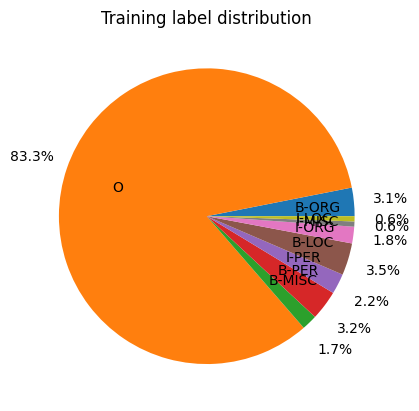

In [57]:
label_list = list(training_gold_labels)
sizes = list(train_label_distribution.values())
labels = [*Counter(label_list)]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
       pctdistance=1.25, labeldistance=.6)
plt.title("Training label distribution")
plt.show()

### Label distribution of the test set

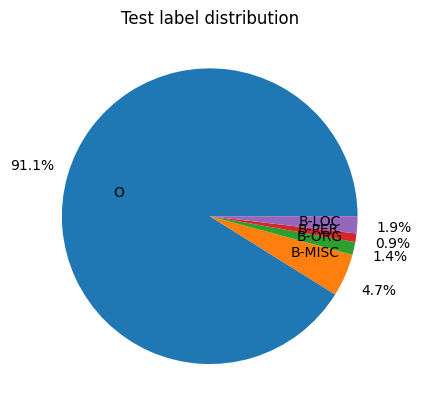

In [68]:
test_label_list = list(test_gold_labels)
test_sizes = list(test_label_distribution.values())
test_labels = [*Counter(test_label_list)]
fig, ax = plt.subplots()
ax.pie(test_sizes, labels=test_labels, autopct='%1.1f%%',
       pctdistance=1.25, labeldistance=.6)
plt.title("Test label distribution")
plt.show()

### LinearSVC

In [18]:
vec = DictVectorizer()
the_array = vec.fit_transform(training_features + test_features)
predit_train = the_array[:len(training_features)]
predit_test = the_array[len(training_features):]

In [19]:
lin_clf = svm.LinearSVC()
lin_clf.fit(predit_train, training_gold_labels)
print(classification_report(test_gold_labels, lin_clf.predict(predit_test)))

              precision    recall  f1-score   support

       B-LOC       1.00      0.25      0.40         4
      B-MISC       1.00      0.30      0.46        10
       B-ORG       0.00      0.00      0.00         3
       B-PER       0.67      1.00      0.80         2
      I-MISC       0.00      0.00      0.00         0
       I-ORG       0.00      0.00      0.00         0
           O       0.95      0.99      0.97       195

    accuracy                           0.93       214
   macro avg       0.52      0.36      0.38       214
weighted avg       0.93      0.93      0.92       214



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1